*Extra analysis of the subway service ridership scripts*. In particular, applying different factors to get a better estimate of 2025 ridership. 

# Imports/Installation

In [81]:
import gtfs_kit as gk
import pandas as pd 
import folium
from geodatasets import get_path
import shapely
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import tab20
import matplotlib.cm as cm
import matplotlib.colors as mcolors
mpl.rcParams['figure.dpi'] = 150
sns.set(style='whitegrid')

In [82]:
orig_stations_df = pd.read_csv("../data/MTA_Subway_Stations_20240325.csv")
orig_stations_df = orig_stations_df[orig_stations_df['Borough']!='SI'] 
orig_stations_df = orig_stations_df.drop(columns=['Division', 'ADA', 'ADA Northbound', 'ADA Southbound', 'ADA Notes'
                                                , 'North Direction Label', 'South Direction Label'])

In [ ]:
yearly_ridership = pd.read_csv("../saved_data/routes_yearly_ridership.csv", index_col=0)
day_hour_ridership = pd.read_csv("../saved_data/routes_day_hour_ridership.csv", index_col=0)
routes_day_hour_station_ridership = pd.read_csv("../saved_data/routes_day_hour_station_ridership.csv", index_col=0)


In [ ]:
yearly_ridership['yearly_ridership_unlinked_MM'].sum()
## 1.7 billion (unlinked) riders were taken on weekdays (87% of total)
(sum(yearly_ridership['daily_ridership_weekday'] * 1000) * 52.14 * 5 * 1.69 * 1.08 ) / 1000000

np.float64(2020.4)

In [13]:
# 2.189 billion unlinked riders in 2025
# 827 MM riders in A Division (34%)
yearly_ridership[yearly_ridership['route_id'].isin(['1', '2', '3', '4', '5', '6', '7', 'GS'])]['Adjusted_unlinked_2025'].sum()
# yearly_ridership

np.float64(896.8399999999999)

## Hourly Ridership Analysis

In [ ]:
# most and least used routes days and hours
day_hour_ridership.sort_values(by='route_id_ridership')

,day_of_week,hour,route_id_ridership
route_id,,,
FS,Weekday,2,4.281380
H,Weekday,1,5.043710
H,Sunday,2,5.789125
FS,Weekday,1,6.513276
FS,Sunday,3,6.738351
...,...,...,...
7,Weekday,17,27694.492738
7,Weekday,8,29572.790235
6,Weekday,16,30204.267721


In [104]:
# which service is most slammed at peak times? (6-9, 15-18)
day_hour_ridership_weekday = day_hour_ridership[(day_hour_ridership['day_of_week']=='Weekday')&(day_hour_ridership['hour'].isin([6,7,8,15,16,17,18]))]
rush_hour_ridership = pd.DataFrame(day_hour_ridership_weekday.groupby(['route_id', 'hour'])['route_id_ridership'].sum())


In [105]:
# only keeping rows with max ridership (https://stackoverflow.com/questions/43899886/how-do-i-just-keep-the-rows-with-the-maximum-value-in-a-column-for-items-of-the)
max_rush_hour_ridership = rush_hour_ridership.loc[rush_hour_ridership.groupby('route_id')['route_id_ridership'].idxmax()]
max_rush_hour_ridership.sort_values(by='route_id_ridership', ascending=False)

,,route_id_ridership
route_id,hour,
6,17,34650.933321
1,17,32508.351278
7,8,29572.790235
F,17,27663.157215
R,17,25079.656878
E,17,23574.852048
N,17,22831.831934
A,17,20589.066268
Q,8,19043.812907


## Plots of Service Ridership

<Axes: >

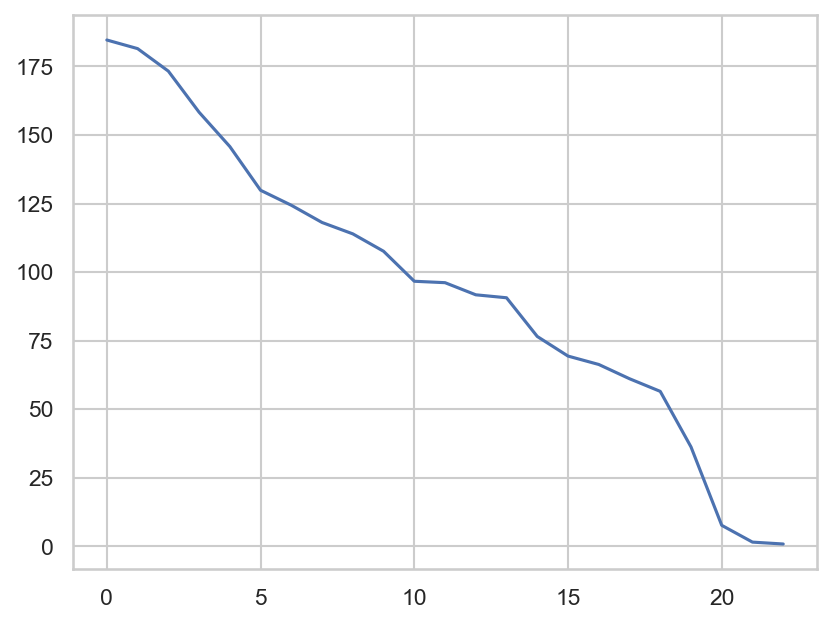

In [106]:
# speed, especially at late nights, depends on how "local" the services are
yearly_ridership['Adjusted_unlinked_2025'].plot()

In [107]:
color_list = ['#D82233',  '#009952', '#9A38A1', '#EB6800', '#F6BC26', '#F6BC26'
              , '#0062CF', '#0062CF', '#F6BC26', '#D82233', '#7C858C'
              , '#009952',  '#EB6800', '#0062CF','#D82233', '#009952',
              '#EB6800', '#EB6800', '#8E5C33', '#799534'
              , '#7C858C','#7C858C', '#7C858C']

/var/folders/8x/kvnrx4697fv2091hzl57dkbr0000gn/T/ipykernel_15877/1703298805.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(yearly_ridership, x='route_id', y='Adjusted_unlinked_2025'


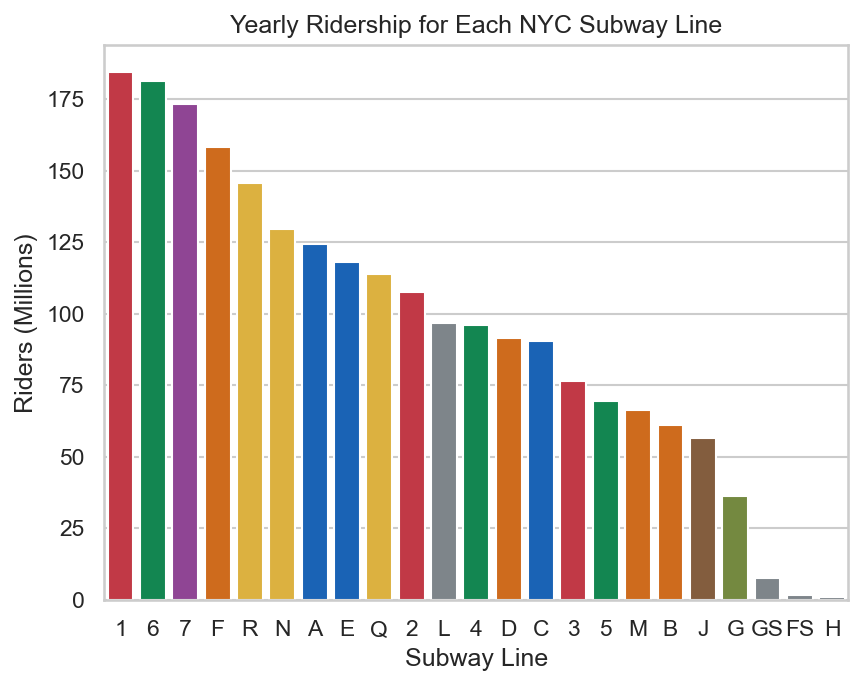

In [108]:
ax = sns.barplot(yearly_ridership, x='route_id', y='Adjusted_unlinked_2025'
            , palette=sns.color_palette(color_list))
ax.set_title("Yearly Ridership for Each NYC Subway Line")
ax.set_ylabel("Riders (Millions)")
ax.set_xlabel("Subway Line")
fig = ax.get_figure()
# fig.savefig("../saved_data/yearly_service_ridership_plot.png")

## Plotting Daily Riders

In [115]:
color_list_daily = [ '#009952', '#D82233', '#9A38A1', '#EB6800', '#F6BC26', '#F6BC26'
              , '#0062CF', '#0062CF', '#F6BC26', '#D82233', '#009952',
              '#7C858C',   '#EB6800', '#0062CF',  '#EB6800', '#D82233',  '#EB6800'
              ,'#009952', '#8E5C33', '#799534', '#7C858C','#7C858C', '#7C858C']
daily_ridership_df = yearly_ridership.sort_values(by='Adjusted_unlinked_2025_daily_thousands', ascending=False)

/var/folders/8x/kvnrx4697fv2091hzl57dkbr0000gn/T/ipykernel_15877/2764777586.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(daily_ridership_df, x='route_id', y='Adjusted_unlinked_2025_daily_thousands'


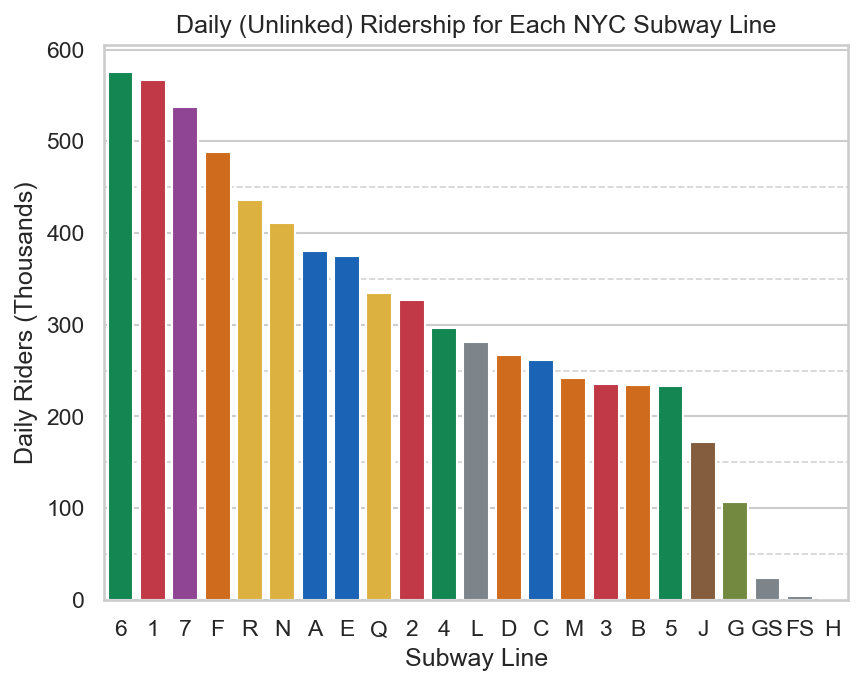

In [116]:
ax = sns.barplot(daily_ridership_df, x='route_id', y='Adjusted_unlinked_2025_daily_thousands'
            , palette=sns.color_palette(color_list_daily))
for y in range(0, 500, 50):
    ax.axhline(y=y, linestyle='--', color='lightgray', linewidth=0.8, zorder=0)
ax.set_title("Daily (Unlinked) Ridership for Each NYC Subway Line")
ax.set_ylabel("Daily Riders (Thousands)")
ax.set_xlabel("Subway Line")
fig = ax.get_figure()
fig.savefig("../saved_data/daily_service_ridership_plot.png")

In [ ]:
# comparisons to MTA numbers
mta_a_c_daily = 600000
a_c_daily_ridership = daily_ridership_df[daily_ridership_df['route_id'].isin(['A', 'C'])]['Adjusted_unlinked_2025_daily_thousands'].sum() * 1000
# 7 % difference for A/C! 
a_c_daily_ridership / mta_a_c_daily

np.float64(1.0708)

In [ ]:
mta_6_daily = 600000
daily_ridership_6 = daily_ridership_df[daily_ridership_df['route_id'].isin(['6'])]['Adjusted_unlinked_2025_daily_thousands'].sum() * 1000
# 4% difference for A/C! 
daily_ridership_6 / mta_6_daily

np.float64(0.9597333333333333)

## Plotting Crowdedness

In [130]:
color_list_crowdedness = [ '#7C858C', '#9A38A1', '#D82233', '#0062CF', '#009952'
              , '#0062CF', '#EB6800', '#F6BC26', '#F6BC26', '#EB6800', '#D82233'
              , '#009952','#F6BC26', '#799534',  '#009952', '#0062CF',
              '#EB6800', '#EB6800', '#7C858C', '#D82233'
              , '#7C858C', '#8E5C33','#7C858C']

/var/folders/8x/kvnrx4697fv2091hzl57dkbr0000gn/T/ipykernel_15877/4010019975.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(yearly_ridership_corwdedness_sort, x='route_id', y='crowdedness_unlinked'


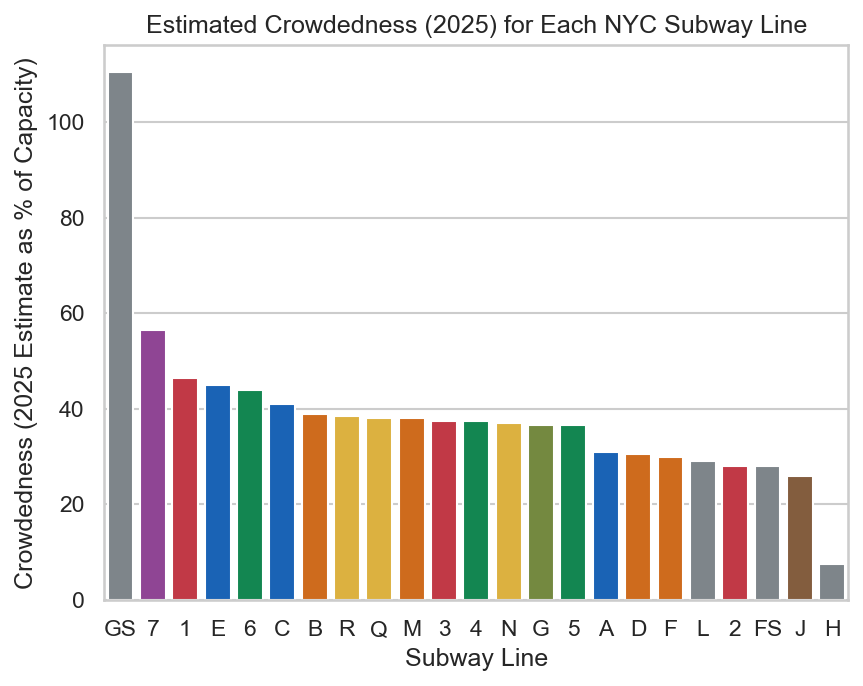

In [131]:
yearly_ridership_corwdedness_sort = yearly_ridership.sort_values(by='crowdedness_unlinked', ascending=False)
yearly_ridership_corwdedness_sort['crowdedness_unlinked'] = (yearly_ridership_corwdedness_sort['crowdedness_unlinked'] * 100) / 2
ax = sns.barplot(yearly_ridership_corwdedness_sort, x='route_id', y='crowdedness_unlinked'
            , palette=sns.color_palette(color_list_crowdedness))
ax.set_title("Estimated Crowdedness (2025) for Each NYC Subway Line")
ax.set_ylabel("Crowdedness (2025 Estimate as % of Capacity)")
ax.set_xlabel("Subway Line")
fig = ax.get_figure()
fig.savefig("../saved_data/yearly_crowdedness_plot.png")

# Comparing to MTA Pre-Covid Rush Hour Data

In [14]:
a_div_df = pd.read_csv("../one_off_data/A_division_peak.txt", header=None)
a_div_df.columns = ['service', 'peak_load_point', 'peak_volume', 'tph', 'v/c_ratio']
a_div_df = a_div_df[['service', 'peak_volume']]
a_div_df = pd.DataFrame(a_div_df.groupby('service')['peak_volume'].sum()).reset_index().sort_values(by='peak_volume')

In [ ]:

b_div_df = pd.read_csv("../one_off_data/B_division_peak.txt", header=None)
b_div_df.columns = ['service', 'peak_load_point', 'peak_volume', 'tph', 'v/c_ratio']
b_div_df = b_div_df[['service', 'peak_volume']]
b_div_df = pd.DataFrame(b_div_df.groupby('service')['peak_volume'].sum()).reset_index().sort_values(by='peak_volume')

: 

: 

In [ ]:
peak_service_volume_df = pd.concat([a_div_df, b_div_df]).sort_values(by='peak_volume', ascending=False)

: 

: 

In [ ]:
peak_service_volume_df

,service,peak_volume
5,F,35727
6,7,30430
4,5,30160
0,A,29620
10,N,29319
5,6,28692
11,Q,26523
3,4,25822
8,L,22941
4,E,21149


: 

: 